In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle

In [4]:
# DATA ARR 4 IS THE ONE THEY USED
data = pickle.load( open( "sparse_light_curves_python2.pickle", "rb" ) )

kdata = np.load('KeplerSampleFullQ.npy',encoding='bytes')
def real_plot(num):
    x = kdata[num][0]
    y = kdata[num][1]
    y_err = kdata[num][2]
    plt.plot(x, y)
    
def plot_sparse(data_arr, lc_index):
    if data_arr >= 3:
        x = data[data_arr][lc_index].T[0]
        y = data[data_arr][lc_index].T[1]
        plt.plot(x,y)
    else:
        x = data[data_arr][lc_index][0]
        y = data[data_arr][lc_index][1]
        plt.plot(x,y)

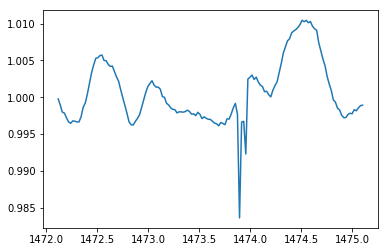

In [5]:
# Tabby's star
plot_sparse(4, 1156)

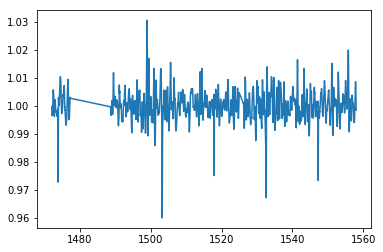

In [6]:
real_plot(1156)

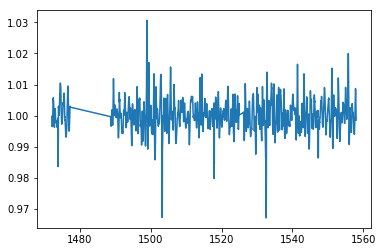

In [7]:
plot_sparse(6, 1156)

# dmdt generation

In [218]:
dmints = [-1.0, -0.02, -0.01, -0.008, -0.006, -0.005, -0.004, -0.003, -0.0012, 
          -0.001, -0.0008, -0.0006, -0.0003, -0.0001, 0,  0.0001, 0.0003, 0.0006, 0.0008, 0.001, 0.0012, 0.003, 
          0.004, 0.005, 0.006, 0.008, 0.01, 0.02, 1.0]
dtints = [1.0/47, 2.0/47, 5.0/47, 8.0/47, 10.0/47, 15.0/47, 20.0/47, 25.0/47, 30.0/47, 40.0/47, 45.0/47, 
          1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 2.5, 3.0, 3.25, 3.5, 4.0, 4.5, 5.0, 5.5, 5.7, 6.0, 15.0]

print len(dmints)
print len(dtints)

def pairwisediffs(arrayoned):
    x = arrayoned.reshape((1,len(arrayoned)))
    xdm = x[:] - np.transpose(x[:])
    xd = xdm[np.triu_indices(len(x[0]), k = 1)]
    return(xd)
def get2dhist(lightcurve):
    xd = pairwisediffs(lightcurve[0])
    yd = pairwisediffs(lightcurve[1])
    H,xe,ye = np.histogram2d(xd,yd,bins=[dtints,dmints],range=None,normed=False)
    G = 255*H/np.sum(H)
    return G

def save_dmdt(n):
    fastdmdt = get2dhist([data[4][n].T[0],data[4][n].T[1]])
    np.save("sparse_light_curve_dmdt/im_" + str(n), fastdmdt.T)
    return fastdmdt.T

29
29


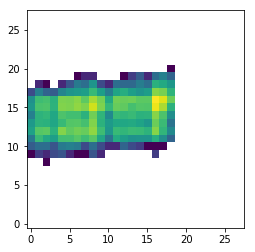

In [219]:
test_x = data[4][1159].T[0]
test_y = data[4][1159].T[1]

fastdmdt = get2dhist([test_x,test_y])
plt.imshow(fastdmdt.T,  norm = LogNorm(), origin="lower")

In [220]:
full_data = []
for i, _ in enumerate(data[4]):
    if i % 100 == 0:
        print "ON ITERATION: " + str(i)
    fastdmdt = save_dmdt(i)
    full_data.append(fastdmdt)
full_data = np.array(full_data)

ON ITERATION: 0
ON ITERATION: 100
ON ITERATION: 200
ON ITERATION: 300
ON ITERATION: 400
ON ITERATION: 500
ON ITERATION: 600
ON ITERATION: 700
ON ITERATION: 800
ON ITERATION: 900
ON ITERATION: 1000
ON ITERATION: 1100
ON ITERATION: 1200
ON ITERATION: 1300
ON ITERATION: 1400
ON ITERATION: 1500
ON ITERATION: 1600
ON ITERATION: 1700
ON ITERATION: 1800
ON ITERATION: 1900
ON ITERATION: 2000
ON ITERATION: 2100
ON ITERATION: 2200
ON ITERATION: 2300
ON ITERATION: 2400


In [223]:
np.save("sparse_light_curve_dmdt/full_sparse_light_curve_points.npy", full_data)

# outlier detection

In [13]:
from sklearn.manifold import TSNE
import umap
import mpld3

full_data = np.load("sparse_light_curve_dmdt/full_sparse_light_curve_points.npy")

full_data.shape
reshaped_data = full_data.reshape(2500, 784)

weird_points = [704, 1109, 1102, 2344, 1944, 363, 34, 1174, 90, 1258, 1411, 1145]
def plot_lc(emedded_mat, title, outliers=None, baseline_outliers=weird_points, save_plot=False):
    x = emedded_mat[:, 0]
    y = emedded_mat[:, 1]
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    N = len(x)
    hehe = []
    s = []
    shapes = []
    for i in range(N):
        if i == 1156:
            hehe.append('r')
            s.append(80)
        if i in baseline_outliers:
            hehe.append('g')
            s.append(30)
            shapes.append("x")
#         elif i in outliers:
#             hehe.append('b')
#             s.append(20)
#             shapes.append("+") 
        else:
            hehe.append("#660066")
            s.append(1)
            shapes.append(".")
        
    hehe = np.array(hehe)
    s = np.array(s)
    
    scatter = ax.scatter(x,
                         y,
                         c=hehe,
                         s=s,
                         alpha=0.3,
                         zorder=10)
    ax.grid(color='white', linestyle='solid', zorder=0)

    ax.set_title(title, size=15)
    
    if save_plot:
        plt.savefig("final_images/" + str(title) +".ps", dpi=1500)

    labels = ['point {0}'.format(i + 1) for i in range(N)]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

In [10]:
p = 200
ee = 5
lr = 50

model_tsne_2 = TSNE(n_components=2, perplexity=p, early_exaggeration=ee, learning_rate=lr)
embeddings_tsne_784_2 = model_tsne_2.fit_transform(reshaped_data)
print model_tsne_2.kl_divergence_

0.344261914492


In [11]:
neighbors = 200
min_dist = 1.0

model_umap_2 = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist)
embeddings_umap_784_2 = model_umap_2.fit_transform(reshaped_data)

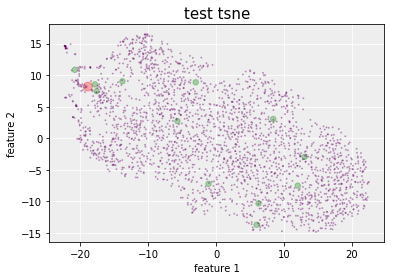

In [14]:
plot_lc(embeddings_tsne_784_2, "test tsne")

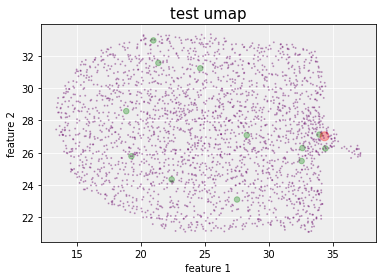

In [15]:
plot_lc(embeddings_umap_784_2, "test umap")

# final outliers finding

In [263]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=30)
pca_embeddings = pca_model.fit_transform(reshaped_data)

p = 200
ee = 5
lr = 50
tsne_model = TSNE(n_components=2, perplexity=p, early_exaggeration=ee, learning_rate=lr)
tsne_embeddings_pca = tsne_model.fit_transform(pca_embeddings)
print tsne_model.kl_divergence_

0.33636239171


In [264]:
neighbors = 200
min_dist = 1.0

model_umap = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist)
embeddings_umap_pca = model_umap.fit_transform(pca_embeddings)

In [270]:
def find_outliers(distances, metric='min', name="test", cutoff=3):
    if metric == 'average':
        distribution = np.mean(distances, axis=1)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("mean distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        for i in outliers:
            plt.title("outlier " + str(i) + " for embeddings: " + name)
            real_plot(i)
            print normalized[i]
        return outliers
    elif metric == 'min':
        distribution = []
        for i, _ in enumerate(distances):
            min_elem = np.min(np.concatenate((distances[i,:i], distances[i, i+1:]), axis=None))
            distribution.append(min_elem)
        distribution = np.array(distribution)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("min distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        for i in outliers:
            plt.title("outlier " + str(i) + " for embeddings: " + name)
            plot_sparse(4, i)
            plt.show()
            print normalized[i]
        return outliers

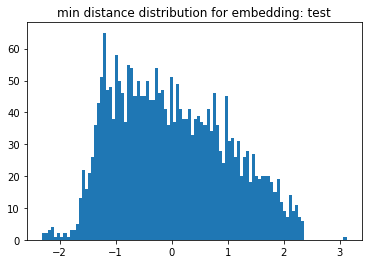

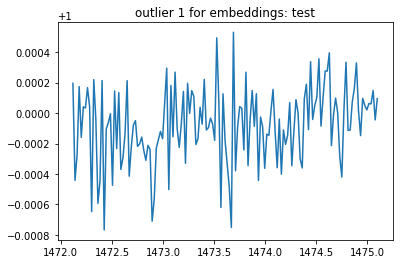

3.1204746


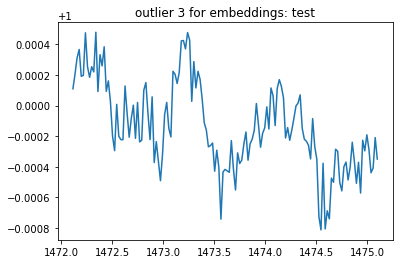

2.3379478


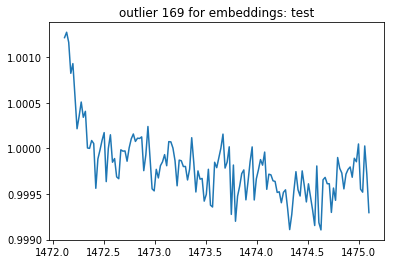

2.3025649


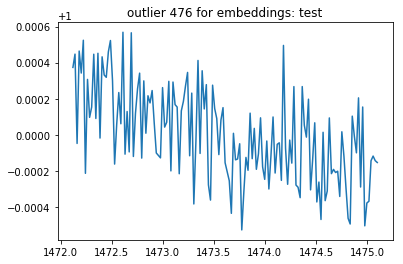

2.3191829


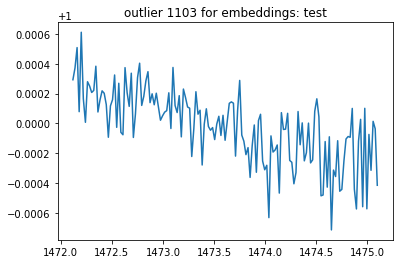

2.3404431


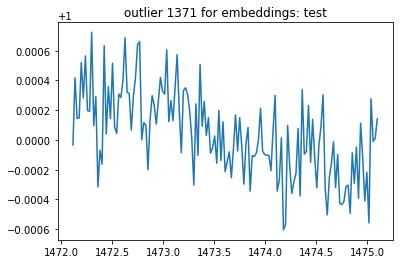

2.3508646


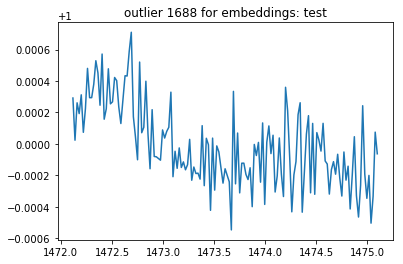

2.3098345


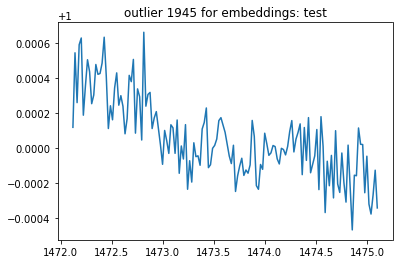

2.3032658


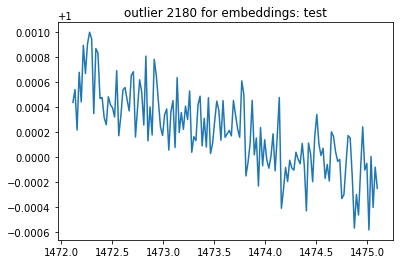

2.3319345


[1, 3, 169, 476, 1103, 1371, 1688, 1945, 2180]

In [275]:
find_outliers(embeddings_umap_pca, cutoff=2.3)

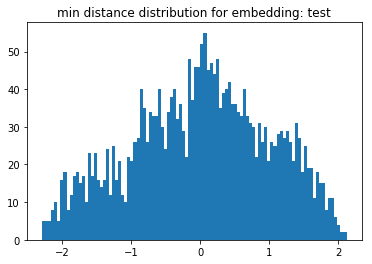

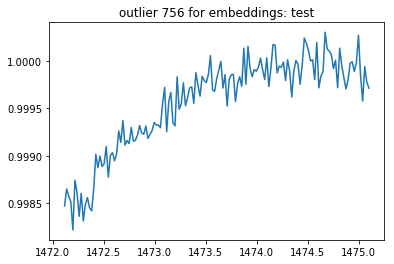

2.0328639


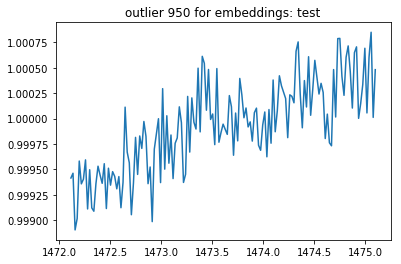

2.0310223


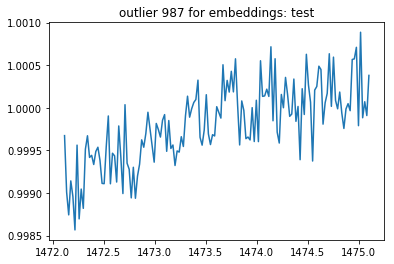

2.003719


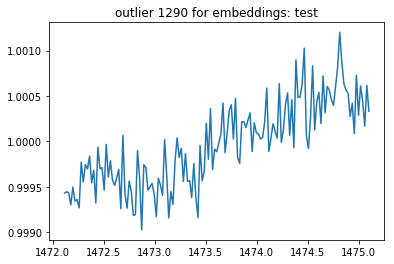

2.0888267


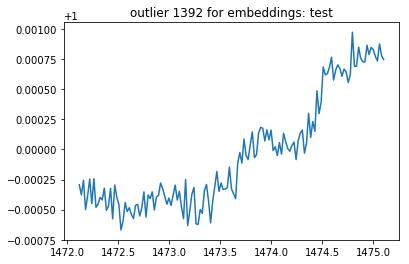

2.1192098


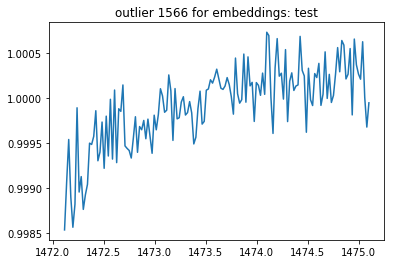

2.0136058


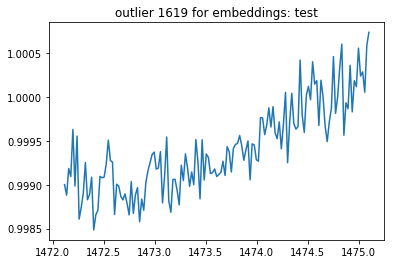

2.0241115


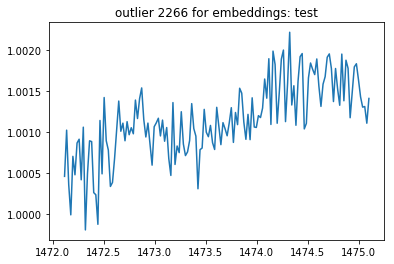

2.000225


[756, 950, 987, 1290, 1392, 1566, 1619, 2266]

In [278]:
find_outliers(tsne_embeddings_pca, cutoff=2.0)